## Deadend 해결

In [7]:
import os
import numpy as np
from crewai import Agent, Task, Crew

os.environ["OPENAI_API_KEY"] = ""

from environment import Environment
import configs
import pickle

with open('./test_set/{}length_{}agents_{}density.pth'.format(40, 4, 0.3), 'rb') as f:
    tests = pickle.load(f)

directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

2024-05-28 13:32:12,805 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    []
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
Since the agent hasn't taken any actions yet, he can't be stuck in a dead end. 

Final Answer: 
No

> Finished chain.
 [DEBUG]: == [Overseer] Task output: No


 [DEBUG]: == Working Agent: Path finder
 [INFO]: == Starting Task: 
    Your current coordinates are (31,9) and your destination is (20,12).
    East and west in the coordinates correspond to the x axis.
    South and north in the coordinated correspond to the y axis.
    You can only move east, west, south and north.
    You can only make one move at a time.
    To your east lies a path.
    To your west lies a path.
    To your south lies a path.
    Your north is blocked by a wall.
    Which direction do you move next?
    
    Answer in one word only: {DIRECTION}
  


> Entering new CrewAgentExecutor chain...


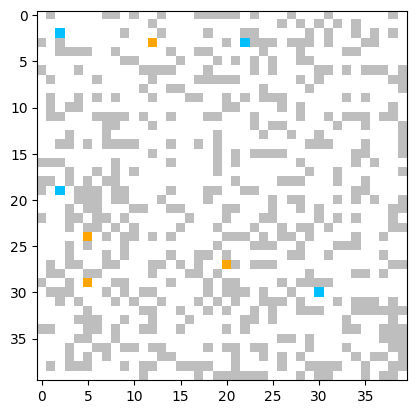

2024-05-28 13:32:28,230 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    ['West']
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
The path finder has only taken one action, which is moving "West". A single action doesn't provide enough information to determine if the path finder is stuck in a dead end. I need more information about the path finder's current position and his surroundings.

Action: Ask question to co-worker
Action Input: {"question": "What is your current position and what are the possible directions you can move in from here?", "context": "You have just moved West. I need to know your current position and the possible paths from your current location to determine if you're stuck in a dead end.", "coworker": "Path finder"}

> Entering new CrewAgentExecutor chain...
I need to determine my current position based on the last known location and direction. I also need to evaluate th

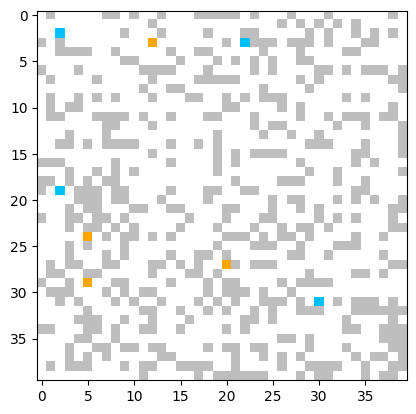

2024-05-28 13:32:53,309 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    ['West', 'South']
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
I need more information to determine if the agent is stuck in a dead end. Specifically, I need to know if there are any other directions the agent could move in from their current location. 

Action: Ask question to co-worker
Action Input: {"question": "What are the possible directions the agent could move in from their current location?", "context": "The agent recently moved 'West' and then 'South'.", "coworker": "Path finder"}

> Entering new CrewAgentExecutor chain...
Given that the agent has recently moved 'West' and then 'South', it's not completely clear where the agent is currently located without a map or a complete understanding of the terrain. However, assuming the agent isn't blocked by any obstacles or boundaries, the possible directions the ag

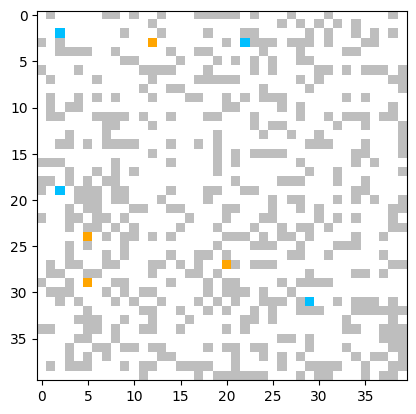

2024-05-28 13:33:11,763 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    ['West', 'South', 'West']
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
Looking at the provided sequence of actions, the pathfinder moved West, then South, then West again. However, without knowing the layout of the environment, it's impossible to determine whether this sequence of actions led the pathfinder into a dead end. I need to ask the pathfinder about the current situation.

Action: 
Ask question to co-worker

Action Input: 
{"question": "Can you describe the environment around you right now?", "context": "You recently moved West, then South, then West again. I am trying to determine whether you are stuck in a dead end.", "coworker": "Path finder"} 


> Entering new CrewAgentExecutor chain...
Based on the recent movements, I can provide a detailed description of the surroundings.

Final Answer: After moving Wes

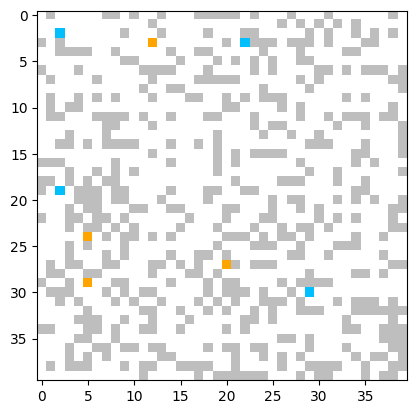

2024-05-28 13:33:44,745 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    ['West', 'South', 'West', 'North']
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
The agent's actions show a pattern of movement which suggests he might be moving in a loop or a square. The sequence of actions, 'West', 'South', 'West', 'North', could indicate this, especially if these actions were repeated. However, it could also just be a coincidence. I need more information to be sure. I'll ask the path finder if this sequence of actions has been repeated recently.

Action: 
Ask question to co-worker

Action Input: 
{
    "question": "Has this sequence of actions - West, South, West, North - been repeated recently?",
    "context": "We are trying to determine if the agent is stuck in a dead end. The agent's recent actions were West, South, West, North. We need to know if this sequence of actions has been repeated rece

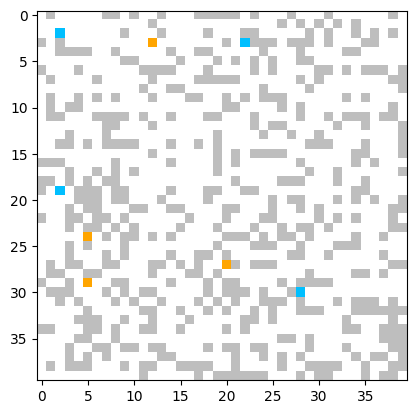

2024-05-28 13:34:13,540 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    ['West', 'South', 'West', 'North', 'West']
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
Looking at the recent actions of the agent, it seems that he might be stuck in a loop or dead end. The sequence 'West', 'South', 'West', 'North', 'West' doesn't show a clear progression towards a destination, especially with the 'North' and 'South' actions cancelling each other out. However, I need more information regarding the terrain or the environment where the agent is operating to make a sure decision.

Action: Ask question to co-worker
Action Input: {"question": "Can you describe the surroundings or environment where you are currently operating?", "context": "The sequence of your moves 'West', 'South', 'West', 'North', 'West' suggests that you might be stuck in a loop or dead end. I need more information to confirm this.", "

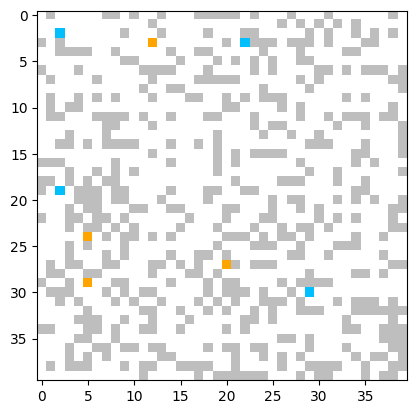

2024-05-28 13:34:42,884 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    ['West', 'South', 'West', 'North', 'West', 'East']
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
The agent seems to be moving in different directions without a clear path. However, to determine if he's stuck in a dead end, we need to verify if he's repeating the same sequence of actions in a loop without making any progress. 

Action: Ask question to co-worker
Action Input: {"question": "Is the agent repeating his actions?", "context": "The agent's last actions were ['West', 'South', 'West', 'North', 'West', 'East'] which seem to lack a clear direction. I want to know if he's stuck in a loop repeating the same sequence of actions.", "coworker": "Path finder"}

> Entering new CrewAgentExecutor chain...
Analyzing the sequence of actions, it appears that the agent is not repeating the same sequence of actions in a loop. T

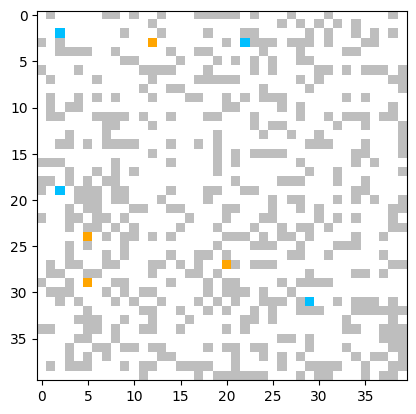

2024-05-28 13:35:39,577 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    ['West', 'South', 'West', 'North', 'West', 'East', 'South']
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
The agent's actions show a possible loop ['West', 'North', 'West', 'East', 'South']. This pattern could indicate that the agent is stuck in a dead end, but it could also mean that the agent is exploring different paths. I need to ask the path finder if he is revisiting already explored areas or if he's exploring new paths.

Action: Ask question to co-worker
Action Input: {"question": "Are you revisiting already explored areas or exploring new paths?", "context": "You have recently taken the following actions: ['West', 'South', 'West', 'North', 'West', 'East', 'South'].", "coworker": "Path finder"}

> Entering new CrewAgentExecutor chain...
Looking at the actions taken, there are directions that indicate a return to

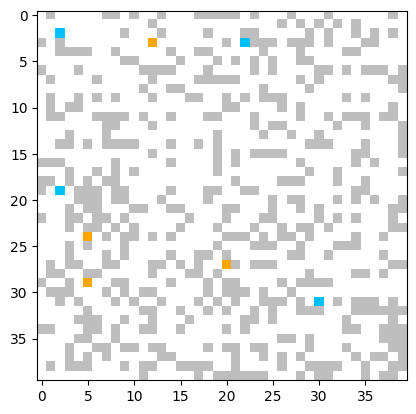

2024-05-28 13:36:01,601 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    ['West', 'South', 'West', 'North', 'West', 'East', 'South', 'East']
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
The agent moved 'West', 'South', 'West', 'North', 'West', 'East', 'South', 'East'. It seems like he might be moving in a loop, which could indicate that he's stuck in a dead end. However, I need to confirm this by analysing his movement pattern more closely. 

Action: Ask question to co-worker
Action Input: {"question": "Can you provide more details about the surrounding environment where the agent is currently located?", "context": "The agent recently moved 'West', 'South', 'West', 'North', 'West', 'East', 'South', 'East'. I suspect he might be stuck in a dead end, but I need more information to confirm this.", "coworker": "Path finder"} 


> Entering new CrewAgentExecutor chain...
From the sequence of mov

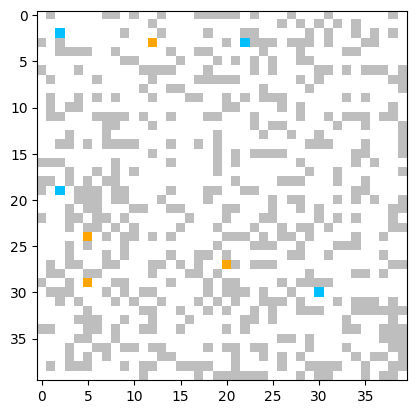

2024-05-28 13:37:01,467 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    ['West', 'South', 'West', 'North', 'West', 'East', 'South', 'East', 'North']
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
Looking at the sequence of actions, I can see that the path finder seems to be moving back and forth between the same points (West and East, South and North). This could mean that he is indeed stuck in a dead end. However, before making a final conclusion, it would be wise to get more context. 

Action: Ask question to co-worker
Action Input: {"question": "Can you provide more context about the area you are in and your current situation?", "context": "You took the following actions: ['West', 'South', 'West', 'North', 'West', 'East', 'South', 'East', 'North']", "coworker": "Path finder"}

> Entering new CrewAgentExecutor chain...
Based on the actions I took, it seems I attempted to navigate through 

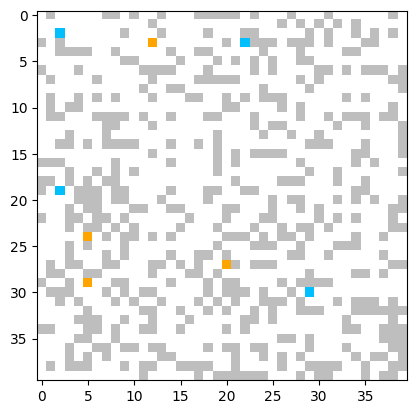

2024-05-28 13:37:30,676 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    ['West', 'South', 'West', 'North', 'West', 'East', 'South', 'East', 'North', 'West']
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
Looking at the sequence of actions, it appears that the agent is moving around a lot without clear progression. Specifically, the sequence 'West, East, South, East, North, West' suggests that the agent might be going in circles. Before making a final decision, I should confirm this with the agent.

Action: Ask question to co-worker
Action Input: {"question": "Can you confirm if you are going in circles or if you are making progress?", "context": "You have recently moved 'West, South, West, North, West, East, South, East, North, West'. This sequence suggests that you might be going in circles. Please clarify.", "coworker": "Path finder"}

> Entering new CrewAgentExecutor chain...
After analy

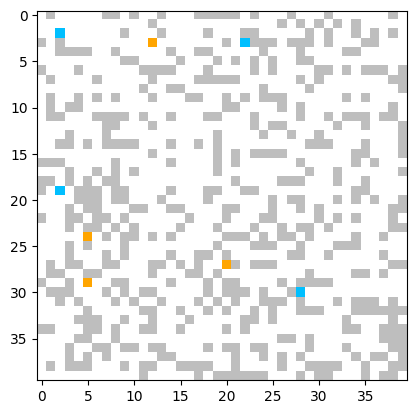

2024-05-28 13:37:51,841 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    ['West', 'South', 'West', 'North', 'West', 'East', 'South', 'East', 'North', 'West', 'West']
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
Looking at the sequence of actions, I notice some repetitions that suggest the agent might be going in circles or backtracking. Specifically, I see a pattern of 'West', 'North', 'West', 'East', 'South', 'East', 'North', 'West' which indicates the agent might be stuck in a loop. However, to be sure, I need to understand if these actions are taken in the same locations or not, as it might just be a coincidence. Therefore, I need to ask the path finder about the locations of these actions to get a clearer picture.

Action: Ask question to co-worker
Action Input: {"question": "Can you provide the locations of the actions taken?", "context": "The sequence of actions taken is ['West', 'So

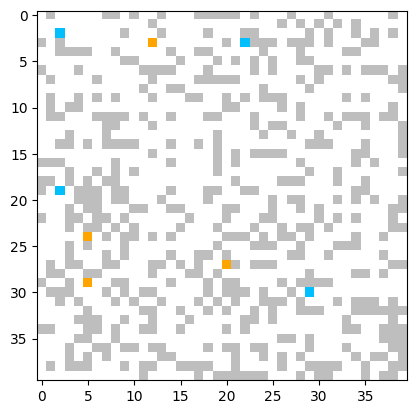

2024-05-28 13:38:23,039 - 27596 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


 [DEBUG]: == Working Agent: Overseer
 [INFO]: == Starting Task: 
    The agent you're monitoring recently took the following actions.
    ['West', 'South', 'West', 'North', 'West', 'East', 'South', 'East', 'North', 'West', 'West', 'East']
    Is he stuck in a dead end?
  


> Entering new CrewAgentExecutor chain...
Looking at the sequence of actions, it seems like the agent might be in a loop, going back and forth without making any real progress. To confirm this, I need to see if the agent is repeating the same sequence of actions over and over again.

Action: Ask question to co-worker
Action Input: {"question": "Is the agent repeating the same sequence of actions?", "context": "The agent has recently taken the following actions: ['West', 'South', 'West', 'North', 'West', 'East', 'South', 'East', 'North', 'West', 'West', 'East']. I suspect that he might be stuck in a loop, going back and forth without making any progress.", "coworker": "Path finder"}

> Entering new CrewAgentExecutor 

KeyError: 'west'

In [10]:
agent0 = Agent(
  role='Path finder',
  goal='Start at the start point and reach the end point without crashing into a wall.',
  backstory="""You are a veteran adventurer with a great sense of direction.
    You understand which direction you need to move to get from where you are to where you want to go.
  """,
  verbose=True,
)

agent1 = Agent(
  role='Overseer',
  goal="""Watch the path finder's behaviour, look at his last actions, and determine if he's stuck in a dead end.
  If he's stuck in a dead end, help him explore other paths.""",
  backstory="""You are a veteran overseer with a great sense of direction.
    You know what sequence of actions of an agent means a dead end.
  """,
  verbose=True,
)

action_list = []

for n in range(50):

  a1_obs = env.observe()[0][1][1]

  x = env.observe()[1][1][1]
  y = 39-env.observe()[1][1][0]

  x_finish = tests[0][2][1][1]
  y_finish = 39-tests[0][2][1][0]

  if a1_obs[4][3] == 0:
    west = """To your west lies a path."""
  else:
    west = """Your west is blocked by a wall."""

  if a1_obs[4][5] == 0:
    east = """To your east lies a path."""
  else:
    east = """Your east is blocked by a wall."""

  if a1_obs[5][4] == 0:
    south = """To your south lies a path."""
  else:
    south = """Your south is blocked by a wall."""

  if a1_obs[3][4] == 0:
    north = """To your north lies a path."""
  else:
    north = """Your north is blocked by a wall."""

  if len(action_list) == 0:
    last_action = """"""
  elif action_list[-1] in ['West', 'West.', 'west']:
    last_action = f"""You came from east."""
  elif action_list[-1] in ['East', 'East.', 'east']:
    last_action = f"""You came from west."""
  elif action_list[-1] in ['South', 'South.', 'south']:
    last_action = f"""You came from north."""
  elif action_list[-1] in ['North', 'North.', 'north']:
    last_action = f"""You came from south."""
  elif action_list[-1] in ['Stay', 'Stay.', 'stay']:
    last_action = f"""You paused once for another agent or you reached your goal."""
  else:
    last_action = """"""

  
  navigation = Task(
  description=(f"""
    Your current coordinates are ({x},{y}) and your destination is ({x_finish},{y_finish}).
    East and west in the coordinates correspond to the x axis.
    South and north in the coordinated correspond to the y axis.
    You can only move east, west, south and north.
    You can only make one move at a time.
    {east}
    {west}
    {south}
    {north}
    Which direction do you move next?
    {last_action}
    Answer in one word only: {{DIRECTION}}
  """),
  expected_output='Direction',
  agent=agent0
  )

  detection = Task(
  description=(f"""
    The agent you're monitoring recently took the following actions.
    {action_list}
    Is he stuck in a dead end?
  """),
  expected_output='Yes or No',
  agent=agent1
  )

  crew = Crew(
    agents=[agent1, agent0],
   tasks=[detection, navigation],
    verbose=2,
  )

  result = crew.kickoff()

  action_list.append(result)
  env.step([0, directiondict[result], 0, 0])
  env.render()